In [38]:
%pip install opendatasets seaborn sklearn numpy matplotlib imblearn


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 189 kB 1.3 MB/s            
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


## Задача

Используя данные португальского банка по обзвону клиентов, научиться определять клиентов, которые с большей вероятностью согласятся сделать срочный вклад при следующем звонке

Таблица содержит информацию о 42639 клиентах:
- `age` – возраст
- `job` – вид деятельности
- `marital` – семейное положение
- `education` – образование
- `default` – наличие просрочки по кредиту
- `housing` – наличие ипотеки
- `loan` – наличие потребительского кредита
- `contact` – тип коммуникации
- `month` – месяц даты последнего взаимодействия
- `day` – день даты последнего взаимодействия
- `duration` – продолжительность последней коммуникации (в секундах)
- `campaign` – количество взаимодействий с клиентом за время текущей кампании
- `pdays` – количество дней, прошедших с момента последнего взаимодействия с клиентом по предыдущей кампании (999 означает, что предыдущих взаимодействий не было)
- `previous` – количество взаимодействий с клиентом до текущей кампании
- `poutcome` – результат предыдущей кампании
- `term_deposit` – результат текущей кампании

Целевой признак – `term_deposit`

In [2]:
import opendatasets as od
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline 

sns.set_style("whitegrid")

In [3]:
od.download('https://www.kaggle.com/kidoen/bank-customers-data')

Skipping, found downloaded files in "./bank-customers-data" (use force=True to force download)


In [4]:
import pandas as pd

data = pd.read_csv('bank-customers-data/BankCustomerData.csv')

In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
42634,21,student,single,secondary,no,2488,no,no,telephone,12,jan,661,2,92,1,success,yes
42635,87,retired,married,primary,no,2190,no,no,telephone,12,jan,512,2,-1,0,unknown,yes
42636,34,blue-collar,married,primary,no,6718,no,no,cellular,13,jan,278,4,97,1,other,no
42637,22,student,single,secondary,no,254,no,no,cellular,13,jan,143,2,-1,0,unknown,yes
42638,32,management,single,tertiary,no,1962,no,no,cellular,13,jan,130,1,-1,0,unknown,no


Приведём данные к условиям задачи. Почему-то отсутсвие прошлых взаимодействий с клиентом обозначено `-1` вместо `999`

In [7]:
data.loc[data['pdays'] == -1, 'pdays'] = 999

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42639 entries, 0 to 42638
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           42639 non-null  int64 
 1   job           42639 non-null  object
 2   marital       42639 non-null  object
 3   education     42639 non-null  object
 4   default       42639 non-null  object
 5   balance       42639 non-null  int64 
 6   housing       42639 non-null  object
 7   loan          42639 non-null  object
 8   contact       42639 non-null  object
 9   day           42639 non-null  int64 
 10  month         42639 non-null  object
 11  duration      42639 non-null  int64 
 12  campaign      42639 non-null  int64 
 13  pdays         42639 non-null  int64 
 14  previous      42639 non-null  int64 
 15  poutcome      42639 non-null  object
 16  term_deposit  42639 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.5+ MB


In [9]:
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'term_deposit']:
  data[col] = data[col].astype('category')
  print(f'* {col} *')
  print(data[col].dtype.categories)
  print('\n')

* job *
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')


* marital *
Index(['divorced', 'married', 'single'], dtype='object')


* education *
Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')


* default *
Index(['no', 'yes'], dtype='object')


* housing *
Index(['no', 'yes'], dtype='object')


* loan *
Index(['no', 'yes'], dtype='object')


* contact *
Index(['cellular', 'telephone', 'unknown'], dtype='object')


* poutcome *
Index(['failure', 'other', 'success', 'unknown'], dtype='object')


* term_deposit *
Index(['no', 'yes'], dtype='object')




## Статистика и визуализация данных

Проверим, насколько сбалансирован датасет

In [10]:
data['term_deposit'].value_counts(normalize=True)

no     0.907104
yes    0.092896
Name: term_deposit, dtype: float64

Информация о категориальных признаках

In [11]:
data.describe(include=['category'])

,job,marital,education,default,housing,loan,contact,poutcome,term_deposit
count,42639,42639,42639,42639,42639,42639,42639,42639,42639
unique,12,3,4,2,2,2,3,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,unknown,no
freq,9536,25868,22066,41828,24590,35554,27218,36085,38678


Информация о числовых признаках

In [12]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000
mean,40.788808,1331.863951,15.854781,255.957504,2.816412,880.389737,0.465442
std,10.200236,3011.537676,8.293901,258.361368,3.163564,281.216872,2.166705
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,62.000000,8.000000,101.000000,1.000000,999.000000,0.000000
50%,39.000000,429.000000,16.000000,177.000000,2.000000,999.000000,0.000000
75%,48.000000,1381.500000,21.000000,315.000000,3.000000,999.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,999.000000,275.000000


Корреляция числовых признаков

In [13]:
corr = data.corr()
corr

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.088716,-0.009869,-0.016529,0.008296,0.025381,-0.016279
balance,0.088716,1.000000,0.004696,0.016721,-0.013358,-0.023346,0.005194
day,-0.009869,0.004696,1.000000,-0.032557,0.165906,0.078238,-0.048445
duration,-0.016529,0.016721,-0.032557,1.000000,-0.085640,0.009700,-0.007730
campaign,0.008296,-0.013358,0.165906,-0.085640,1.000000,0.098311,-0.024374
pdays,0.025381,-0.023346,0.078238,0.009700,0.098311,1.000000,-0.498857
previous,-0.016279,0.005194,-0.048445,-0.007730,-0.024374,-0.498857,1.000000


<AxesSubplot:>

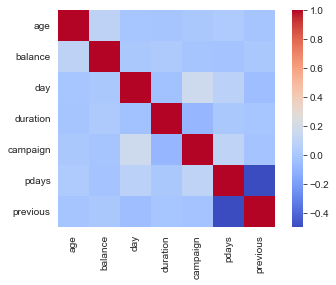

In [14]:
sns.heatmap(corr, square=True, cmap='coolwarm')

Корреляция между `pdays` и `previous` объясняется условием задачи: при отсутствии прошлых звонков клиенту кол-во дней с прошлой коммуникации равно `999`

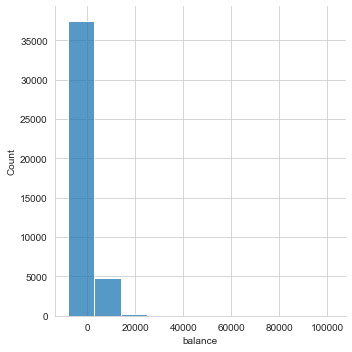

In [15]:
sns.displot(data['balance'], bins=10)

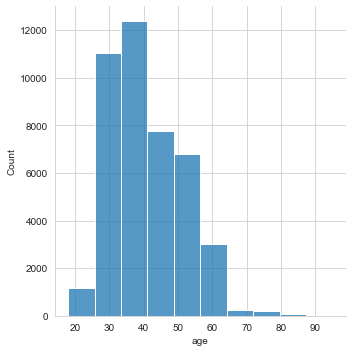

In [16]:
sns.displot(data['age'], bins=10)

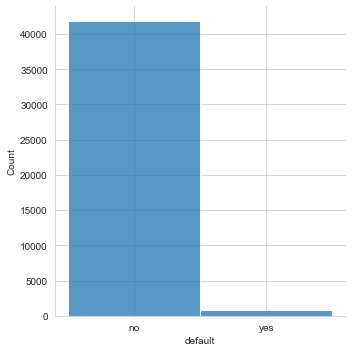

In [17]:
sns.displot(data['default'], bins=10)

## Устранение выбросов

<AxesSubplot:xlabel='age', ylabel='balance'>

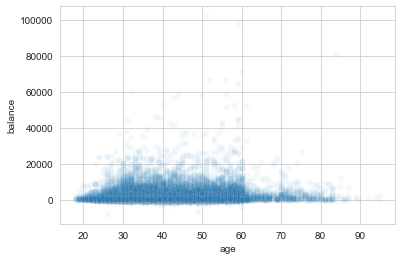

In [18]:
sns.scatterplot(x='age', y='balance', alpha=0.05, data=data)

<AxesSubplot:xlabel='duration', ylabel='campaign'>

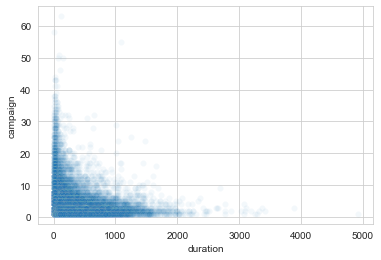

In [19]:
sns.scatterplot(x='duration', y='campaign', alpha=0.05, data=data)

<AxesSubplot:xlabel='pdays', ylabel='previous'>

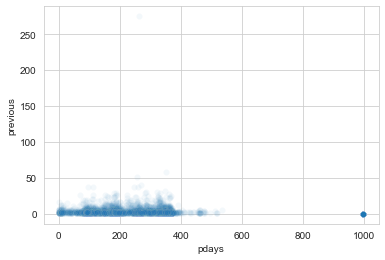

In [20]:
sns.scatterplot(x='pdays', y='previous', alpha=0.05, data=data)

In [21]:
df = pd.DataFrame(data=data, columns=['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'])
low_quantile = 0.005
high_quantile = 0.995
quant_df = df.quantile([low_quantile, high_quantile])
quant_df

,age,balance,duration,campaign,pdays,previous
0.005,22.0,-878.43,9.00,1.0,50.0,0.0
0.995,73.0,17962.67,1507.24,21.0,999.0,11.0


In [22]:
rows_to_drop = data[
  (
    (data['age'] < quant_df.loc[low_quantile, 'age']) | (data['age'] > quant_df.loc[high_quantile, 'age'])
    | ((data['balance'] < quant_df.loc[low_quantile, 'balance']) | (data['balance'] > quant_df.loc[high_quantile, 'balance']))
    | ((data['duration'] < quant_df.loc[low_quantile, 'duration']) | (data['duration'] > quant_df.loc[high_quantile, 'duration']))
    | ((data['campaign'] < quant_df.loc[low_quantile, 'campaign']) | (data['campaign'] > quant_df.loc[high_quantile, 'campaign']))
    | ((data['pdays'] < quant_df.loc[low_quantile, 'pdays']) | (data['pdays'] > quant_df.loc[high_quantile, 'pdays']))
    | ((data['previous'] < quant_df.loc[low_quantile, 'previous']) | (data['previous'] > quant_df.loc[high_quantile, 'previous']))
  )
]

rows_to_drop

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
37,53,technician,married,secondary,no,-3,no,no,unknown,5,may,1666,1,999,0,unknown,no
59,46,services,married,primary,no,179,yes,no,unknown,5,may,1778,1,999,0,unknown,no
152,40,management,married,tertiary,no,-4,yes,no,unknown,5,may,2033,1,999,0,unknown,no
284,30,blue-collar,single,secondary,no,0,yes,no,unknown,5,may,5,2,999,0,unknown,no
287,50,technician,single,tertiary,no,339,yes,no,unknown,5,may,2,3,999,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42608,70,retired,married,primary,no,3230,no,no,cellular,11,jan,300,2,48,1,failure,no
42611,35,technician,single,secondary,no,4645,yes,no,cellular,11,jan,502,3,270,40,other,no
42619,85,retired,married,unknown,no,1934,no,no,telephone,12,jan,140,1,999,0,unknown,no
42634,21,student,single,secondary,no,2488,no,no,telephone,12,jan,661,2,92,1,success,yes


In [23]:
data = data.drop(rows_to_drop.index)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,999,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,999,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,999,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,999,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,999,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42632,29,blue-collar,single,secondary,no,180,no,no,cellular,12,jan,350,2,999,0,unknown,no
42633,49,management,married,tertiary,no,1093,yes,yes,cellular,12,jan,243,2,91,2,success,yes
42636,34,blue-collar,married,primary,no,6718,no,no,cellular,13,jan,278,4,97,1,other,no
42637,22,student,single,secondary,no,254,no,no,cellular,13,jan,143,2,999,0,unknown,yes


<AxesSubplot:xlabel='age', ylabel='balance'>

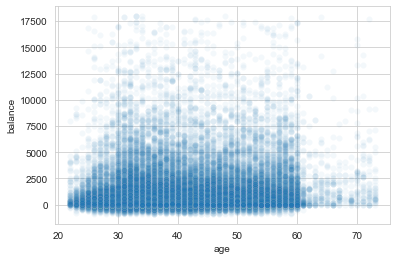

In [24]:
sns.scatterplot(x='age', y='balance', alpha=0.05, data=data)

<AxesSubplot:xlabel='duration', ylabel='campaign'>

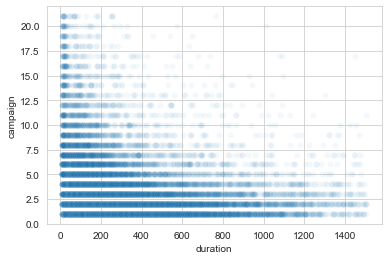

In [25]:
sns.scatterplot(x='duration', y='campaign', alpha=0.05, data=data)

<AxesSubplot:xlabel='pdays', ylabel='previous'>

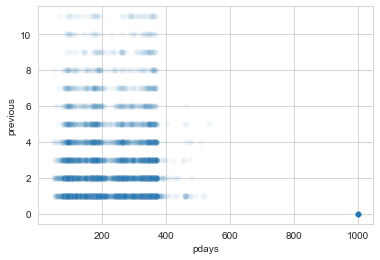

In [26]:
sns.scatterplot(x='pdays', y='previous', alpha=0.05, data=data)

## Устранение пропущенных значений

In [27]:
data.replace(
  {'job': 'unknown', 'education': 'unknown', 'contact': 'unknown'},
  {'job': data['job'].mode().iloc[0], 'education': data['education'].mode().iloc[0], 'contact': data['contact'].mode().iloc[0]},
  inplace=True
)

for col in ['job', 'education', 'contact']:
  data[col].cat.remove_unused_categories()

## Обработка категориальных признаков

Отображение бинарных признаков числами

In [28]:
for col in ['default', 'housing', 'loan', 'term_deposit']:
  data[col] = pd.factorize(data[col], sort=True)[0]

Бинаризация категориальных признаков

In [29]:
for col in ['job', 'marital', 'month', 'education', 'contact', 'poutcome']:
  dummies = pd.get_dummies(data[col])
  data = pd.concat((data, dummies), axis=1)
  data = data.drop([col], axis=1)

## Нормализация признаков

In [30]:
data_norm = (data - data.mean(axis = 0))/data.std(axis = 0)
data_norm

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,sep,primary,secondary,tertiary,cellular,telephone,failure,other,success,unknown
0,1.762928,-0.134771,0.437147,0.85320,-0.446224,-1.309016,0.049724,-0.658733,0.411936,-0.319396,...,-0.076969,-0.426221,-1.126450,1.576157,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
1,0.339546,-0.134771,-0.549557,0.85320,-0.446224,-1.309016,-0.433382,-0.658733,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
2,-0.778825,-0.134771,-0.562159,0.85320,2.240971,-1.309016,-0.762772,-0.658733,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
3,0.644557,-0.134771,0.139829,0.85320,-0.446224,-1.309016,-0.692502,-0.658733,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
4,-0.778825,-0.134771,-0.562625,-1.17203,-0.446224,-1.309016,-0.226964,-0.658733,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42632,-1.185505,-0.134771,-0.479078,-1.17203,-0.446224,-0.462325,0.440601,-0.266837,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803
42633,0.847897,-0.134771,-0.052937,0.85320,2.240971,-0.462325,-0.029329,-0.266837,-2.907312,1.367666,...,-0.076969,-0.426221,-1.126450,1.576157,0.249386,-0.249386,-0.330789,-0.179911,7.509323,-2.404928
42636,-0.677155,-0.134771,2.572516,-1.17203,-0.446224,-0.341369,0.124386,0.516953,-2.885378,0.524135,...,-0.076969,2.346145,-1.126450,-0.634439,0.249386,-0.249386,-0.330789,5.558169,-0.133165,-2.404928
42637,-1.897196,-0.134771,-0.444538,-1.17203,-0.446224,-0.341369,-0.468517,-0.266837,0.411936,-0.319396,...,-0.076969,-0.426221,0.887723,-0.634439,0.249386,-0.249386,-0.330789,-0.179911,-0.133165,0.415803


## Разбиение на обучающую и тестовую выборки

In [31]:
X = data_norm.drop(['term_deposit', 'duration'], axis=1) # duration is unknown before the call
y = data[['term_deposit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print('Train selection size:', X_train.shape[0])
print('Test selection size:', X_test.shape[0])

Train selection size: 28644
Test selection size: 12276


## kNN

### Построим классификатор К-ближайших соседей

In [116]:
for neighbors in [1, 5, 10]:
  knn = KNeighborsClassifier(n_neighbors = neighbors)
  knn.fit(X_train, y_train.values.ravel())
  train_score = knn.score(X_train, y_train)
  test_score = knn.score(X_test, y_test)

  print(f'* Neighbors {neighbors} *')
  print('Train score:', train_score)
  print('Test score:', test_score)
  print('Train error:', 1 - train_score)
  print('Test error:', 1 - test_score)
  print('Confusion matrix:', confusion_matrix(y_test, knn.predict(X_test), normalize='true'))
  print('\n')

* Neighbors 1 *
Train score: 1.0
Test score: 0.8619257086999023
Train error: 0.0
Test error: 0.13807429130009774
Confusion matrix: [[0.92759331 0.07240669]
 [0.80326383 0.19673617]]


* Neighbors 5 *
Train score: 0.9226015919564307
Test score: 0.9086836102965136
Train error: 0.07739840804356934
Test error: 0.09131638970348643
Confusion matrix: [[0.98308422 0.01691578]
 [0.84496827 0.15503173]]


* Neighbors 10 *
Train score: 0.9179234743750873
Test score: 0.9113717823395243
Train error: 0.08207652562491274
Test error: 0.08862821766047568
Confusion matrix: [[0.99096035 0.00903965]
 [0.89483228 0.10516772]]




При увеличении количества соседей точность предсказаний увеличивается, но количество верно найденых потенциальных клиентов уменьшается: при 1 соседе найдено 19.6%, а при 10 – 10.5%

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())
train_score = rf.score(X_train, y_train.values.ravel())
test_score = rf.score(X_test, y_test.values.ravel())

print('Train score:', train_score)
print('Test score:', test_score)
print('Train error:', 1 - train_score)
print('Test error:', 1 - test_score)
print('Confusion matrix:', confusion_matrix(y_test, rf.predict(X_test), normalize='true'))

Train score: 0.9999650886747661
Test score: 0.9112903225806451
Train error: 3.491132523392171e-05
Test error: 0.08870967741935487
Confusion matrix: [[0.99015484 0.00984516]
 [0.88757933 0.11242067]]


Результат похож на метод 10 ближайших соседей

## Gradient Boosting

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train.values.ravel())

train_score = gbt.score(X_train, y_train.values.ravel())
test_score = gbt.score(X_test, y_test.values.ravel())

print('Train score:', train_score)
print('Test score:', test_score)
print('Train error:', 1 - train_score)
print('Test error:', 1 - test_score)
print('Confusion matrix:', confusion_matrix(y_test, gbt.predict(X_test), normalize='true'))

Train score: 0.9196341293115486
Test score: 0.9135711958292604
Train error: 0.08036587068845136
Test error: 0.08642880417073961
Confusion matrix: [[0.99149736 0.00850264]
 [0.87579329 0.12420671]]


Схожий результат

## Устранение несбалансированности классов

In [67]:
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler(random_state=42)

X_train_balanced, y_train_balanced = over.fit_resample(X_train, y_train.values.ravel())

X_train_balanced = pd.DataFrame(X_train_balanced)
y_train_balanced = pd.DataFrame(y_train_balanced)

y_train_balanced.value_counts(normalize=True)

0    0.5
1    0.5
dtype: float64

In [69]:
for neighbors in [1, 5, 10]:
  knn = KNeighborsClassifier(n_neighbors = neighbors)
  knn.fit(X_train_balanced, y_train_balanced.values.ravel())
  train_score = knn.score(X_train_balanced, y_train_balanced)
  test_score = knn.score(X_test, y_test)

  print(f'* Neighbors {neighbors} *')
  print('Train score:', train_score)
  print('Test score:', test_score)
  print('Train error:', 1 - train_score)
  print('Test error:', 1 - test_score)
  print('Confusion matrix:', confusion_matrix(y_test, knn.predict(X_test), normalize='true'))
  print('\n')

* Neighbors 1 *
Train score: 1.0
Test score: 0.8619257086999023
Train error: 0.0
Test error: 0.13807429130009774
Confusion matrix: [[0.92759331 0.07240669]
 [0.80326383 0.19673617]]


* Neighbors 5 *
Train score: 0.9329618566176471
Test score: 0.7725643532095146
Train error: 0.06703814338235292
Test error: 0.22743564679048545
Confusion matrix: [[0.80819834 0.19180166]
 [0.58839529 0.41160471]]


* Neighbors 10 *
Train score: 0.8790785845588235
Test score: 0.7025089605734767
Train error: 0.12092141544117652
Test error: 0.29749103942652333
Confusion matrix: [[0.7212029  0.2787971 ]
 [0.48685403 0.51314597]]




При устранении несбалансированности лучший (для бизнеса) результат показывает сеть 10 ближайших соседей. Хоть общая точность на тестовых данных и уменьшилась, процент нахождения потенциальных клиентов увеличился до 51.3

## Исключение коррелированных переменных

In [74]:
X_train_balanced_new = X_train_balanced.drop(columns=['previous'])
X_test_new = X_test.drop(columns=['previous'])

for neighbors in [1, 5, 10]:
  knn = KNeighborsClassifier(n_neighbors = neighbors)
  knn.fit(X_train_balanced_new, y_train_balanced.values.ravel())
  train_score = knn.score(X_train_balanced_new, y_train_balanced)
  test_score = knn.score(X_test_new, y_test)

  print(f'* Neighbors {neighbors} *')
  print('Train score:', train_score)
  print('Test score:', test_score)
  print('Train error:', 1 - train_score)
  print('Test error:', 1 - test_score)
  print('Confusion matrix:', confusion_matrix(y_test, knn.predict(X_test_new), normalize='true'))
  print('\n')

* Neighbors 1 *
Train score: 1.0
Test score: 0.8622515477354187
Train error: 0.0
Test error: 0.13774845226458132
Confusion matrix: [[0.92786181 0.07213819]
 [0.80235721 0.19764279]]


* Neighbors 5 *
Train score: 0.9326746323529411
Test score: 0.7717497556207233
Train error: 0.06732536764705888
Test error: 0.22825024437927666
Confusion matrix: [[0.80757182 0.19242818]
 [0.59111514 0.40888486]]


* Neighbors 10 *
Train score: 0.8792509191176471
Test score: 0.7035679374389052
Train error: 0.12074908088235292
Test error: 0.2964320625610948
Confusion matrix: [[0.72236642 0.27763358]
 [0.48685403 0.51314597]]




## Выводы

- Устранение несбалансированности классов сильно улучшило результат
- Получилось достигнуть определения 50% потенциальных клиентов

# Полносвязная нейронная сеть

In [75]:
from sklearn.neural_network import MLPClassifier

### Подбор параметра alpha

In [131]:
alpha_nums = np.logspace(-3, 2, 11)
train_acc = []
test_acc = []
train_err = []
test_err = []

for alpha in alpha_nums:
  mlp_model = MLPClassifier(
    alpha = alpha, hidden_layer_sizes = (20,), 
    solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42
  )
  mlp_model.fit(X_train, y_train.values.ravel())

  train_score = mlp_model.score(X_train, y_train)
  test_score = mlp_model.score(X_test, y_test)

  train_acc.append(train_score)
  test_acc.append(test_score)

  train_err.append(1 - train_score)
  test_err.append(1 - test_score)

  print(f'* Alpha: {alpha} *')
  print('Train score:', train_score)
  print('Test score:', test_score)
  print('\n')

* Alpha: 0.001 *
Train score: 0.9289903644742354
Test score: 0.9055066797002281


* Alpha: 0.0031622776601683794 *
Train score: 0.928780896522832
Test score: 0.9059954382535028


* Alpha: 0.01 *
Train score: 0.9277335567658148
Test score: 0.906158357771261


* Alpha: 0.03162277660168379 *
Train score: 0.9264069264069265
Test score: 0.9073802541544477


* Alpha: 0.1 *
Train score: 0.9244518921938277
Test score: 0.9069729553600522


* Alpha: 0.31622776601683794 *
Train score: 0.9253246753246753
Test score: 0.9078690127077224


* Alpha: 1.0 *
Train score: 0.9242075129171904
Test score: 0.9096611274030629


* Alpha: 3.1622776601683795 *
Train score: 0.923963133640553
Test score: 0.9120234604105572


* Alpha: 10.0 *
Train score: 0.9179932970255551
Test score: 0.9117790811339198


* Alpha: 31.622776601683793 *
Train score: 0.9130009775171065
Test score: 0.9119420006516781


* Alpha: 100.0 *
Train score: 0.9131755341432761
Test score: 0.9113717823395243




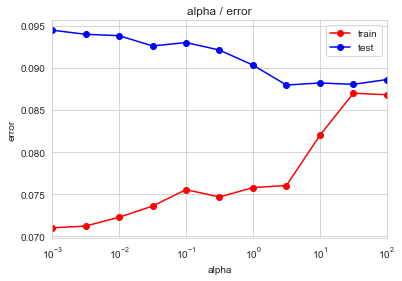

In [133]:
plt.semilogx(alpha_nums, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_nums, test_err, 'b-o', label = 'test')
plt.xlim([np.min(alpha_nums), np.max(alpha_nums)])
plt.title('alpha / error')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

In [130]:
best_index = np.where(test_acc == np.max(test_acc))[0][0]

print('Best alpha:', alpha_nums[best_index])
print('Best test score:', test_acc[best_index])
print('Best train score:', train_acc[best_index])

Best alpha: 3.1622776601683795
Best test score: 0.9120234604105572
Best train score: 0.923963133640553


При альфа > 3.16 точность на тестовом сете начинает падать из-за переобучения

### Подбор количества нейронов в первом скрытом слое

In [135]:
neurons_nums = [x for x in range(10, 101, 10)]
test_err2 = []
train_err2 = []
train_acc2 = []
test_acc2 = []

for neurons_num in neurons_nums:
  mlp_model = MLPClassifier(
    alpha = alpha_nums[best_index], hidden_layer_sizes = (neurons_num,), solver = 'lbfgs', 
    max_iter = 1000, activation = 'logistic', random_state = 42
  )
    
  mlp_model.fit(X_train, y_train.values.ravel())

  train_score = mlp_model.score(X_train, y_train)
  test_score = mlp_model.score(X_test, y_test)

  train_acc2.append(train_score)
  test_acc2.append(test_score)

  train_err2.append(1 - train_score)
  test_err2.append(1 - test_score)

  print(f'* Neurons: {neurons_num} *')
  print('Train score:', train_score)
  print('Test score:', test_score)
  print('\n')

* Neurons: 10 *
Train score: 0.9190755481078061
Test score: 0.912593678722711


* Neurons: 20 *
Train score: 0.923963133640553
Test score: 0.9120234604105572


* Neurons: 30 *
Train score: 0.9268956849602011
Test score: 0.9108830237862496


* Neurons: 40 *
Train score: 0.9315039798910767
Test score: 0.9084392310198762


* Neurons: 50 *
Train score: 0.9340525066331518
Test score: 0.9068100358422939


* Neurons: 60 *
Train score: 0.93251640832286
Test score: 0.9108830237862496


* Neurons: 70 *
Train score: 0.9348205557882977
Test score: 0.907624633431085


* Neurons: 80 *
Train score: 0.9319229157938835
Test score: 0.9094167481264256


* Neurons: 90 *
Train score: 0.9354489596425081
Test score: 0.908357771260997


* Neurons: 100 *
Train score: 0.9320276497695853
Test score: 0.9101498859563376




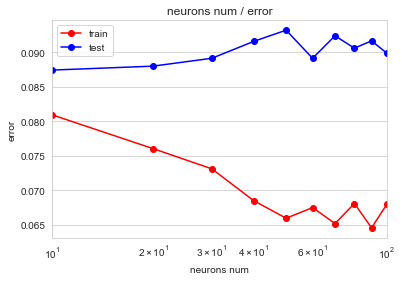

In [136]:
plt.semilogx(neurons_nums, train_err2, 'r-o', label = 'train')
plt.semilogx(neurons_nums, test_err2, 'b-o', label = 'test')
plt.xlim([np.min(neurons_nums), np.max(neurons_nums)])
plt.title('neurons num / error')
plt.xlabel('neurons num')
plt.ylabel('error')
plt.legend()

In [137]:
best_index = np.where(test_acc2 == np.max(test_acc2))[0][0]

print('Best neurons num:', neurons_nums[best_index])
print('Best test score:', test_acc2[best_index])
print('Best train score:', train_acc2[best_index])

Best neurons num: 10
Best test score: 0.912593678722711
Best train score: 0.9190755481078061


### Одновременный перебор alpha и количества нейронов скрытого слоя (для нейронной сети с одним скрытым слоем)

In [82]:
neurons_nums = [x for x in range(10, 101, 10)]
alpha_nums = np.logspace(-3, 2, 11)
train_acc = []
test_acc = []

runs = []

for index, neurons_num in enumerate(neurons_nums):
  runs.append({
    'train_scores': np.array([]),
    'test_scores': np.array([]),
  })
  for alpha in alpha_nums:
    mlp_model = MLPClassifier(
      alpha = alpha, hidden_layer_sizes = (neurons_num,), 
      solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42
    )
    mlp_model.fit(X_train, y_train.values.ravel())

    train_score = mlp_model.score(X_train, y_train)
    test_score = mlp_model.score(X_test, y_test)

    runs[index]['train_scores'] = np.append(runs[index]['train_scores'], train_score)
    runs[index]['test_scores'] = np.append(runs[index]['test_scores'], test_score)

runs

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[{'train_scores': array([0.91900573, 0.91907555, 0.91883117, 0.91911046, 0.91907555,
         0.91963413, 0.9192501 , 0.91907555, 0.91694596, 0.9130708 ,
         0.91321045]),
  'test_scores': array([0.91039427, 0.90917237, 0.91063864, 0.91202346, 0.91104594,
         0.91226784, 0.91300098, 0.91259368, 0.91365266, 0.911942  ,
         0.9115347 ])},
 {'train_scores': array([0.92899036, 0.9287809 , 0.92773356, 0.92640693, 0.92445189,
         0.92532468, 0.92420751, 0.92396313, 0.9179933 , 0.91300098,
         0.91317553]),
  'test_scores': array([0.90550668, 0.90599544, 0.90615836, 0.90738025, 0.90697296,
         0.90786901, 0.90966113, 0.91202346, 0.91177908, 0.911942  ,
         0.91137178])},
 {'train_scores': array([0.93806731, 0.93548387, 0.93513476, 0.93283061, 0.93167854,
         0.93021226, 0.93000279, 0.92689568, 0.91792347, 0.913385  ,
         0.91317553]),
  'test_scores': array([0.89141414, 0.89336918, 0.89760508, 0.89833822, 0.90281851,
         0.90428478, 0.90615836

In [91]:
max_test_scores = []
max_test_score_alphas = []

for run in runs:
  max_test_score = np.max(run['test_scores'])
  max_test_scores.append(max_test_score)
  max_test_score_index = np.where(run['test_scores'] == max_test_score)[0][0]
  max_test_score_alphas.append(alpha_nums[max_test_score_index])

max_test_score = np.max(max_test_scores)
max_test_score_index = np.where(max_test_scores == max_test_score)[0][0]

print('Max test score:', max_test_scores[max_test_score_index])
print('Alpha:', max_test_score_alphas[max_test_score_index])
print('Neurons:', neurons_nums[max_test_score_index])
  

Max test score: 0.9136526555881395
Alpha: 10.0
Neurons: 10


## Выводы

Лучший результат достигается при альфа = 10, количество нейронов в первом скрытом слое = 10